In [ ]:
import requests
from bs4 import BeautifulSoup 
import csv
import urllib.request

#Selenium Packages
!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from datetime import datetime

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import pandas as pd

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Google Colab is quite annoying when using selenium.
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
#source = https://stackoverflow.com/questions/56829470/selenium-google-colab-error-chromedriver-executable-needs-to-be-in-path

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1,376 kB]
Get:15 http:/

# Web-Scraping & Sentiment Analysis


In [ ]:
driver = webdriver.Chrome('chromedriver',options=options)
driver.get("https://www.fool.com/quote/nyse/altria-group/mo/")

for i in range(0,40): #We automated the "Load More" button to be clicked 40 times. 
  button_css = driver.find_element_by_css_selector("#load-more")
  button_css.click()
  WebDriverWait(driver, 10).until(EC.element_to_be_clickable( 
    (By.CSS_SELECTOR, "#load-more")))
  i+=1

data = driver.page_source 
soup=BeautifulSoup(data)

titles = []
agg_titles_pv = []
date = []
proc_date = []

for t in (soup.find_all("div", {"class": "card-image"})): 
  title = t.find_next()
  titles.append(title['title'])
for n in (soup.find_all("div", {"class": "story-date-author"})):
  date.append(n.text)


for x in range(0, len(titles)):
  date[x] = (date[x][len(date[x])-12:]) #The original date provides us with both the Author and date. In order to extract just the date, we subtract the length of the whole string by the size of the date(-12)
  strip_date = date[x].lstrip()
  if len(strip_date)<12:
    strip_date1 = (''.join(x.zfill(3) for x in strip_date.split(' ')))
    strip_date2=(strip_date1[0:3]+ ' ' + strip_date1[3:6] + " " + strip_date1[6:10]) #formating string to appropriate structure for the .strptime function. 
    n_date= datetime.strptime(strip_date2,'%b %d, %Y').date()
    proc_date.append(n_date)
  else:
    n_date = datetime.strptime(strip_date,'%b %d, %Y').date()
    proc_date.append(n_date)


sid = SentimentIntensityAnalyzer()

for z in range(0, len(titles)):
  if titles[z]== None:
    pass
  else:
    titles_pv = (sid.polarity_scores(titles[z]))#Sentiment analysis of titles. 
    agg_titles_pv.append(titles_pv['compound'])#Discarding all sentiments EXCEPT compound
  
df = pd.DataFrame(list(zip(titles,proc_date,agg_titles_pv)), #create a dataframe because it is much easier to manipulate/ handle
                 columns = ['Title', 'Date',"Aggr. Title Polarity"])
df["Date"] = pd.to_datetime(df.Date)
df= df.groupby(['Date']).mean()
df




,Aggr. Title Polarity
Date,
2017-10-27,0.0000
2017-10-31,-0.3182
2017-11-01,0.2960
2017-11-15,0.0000
2017-11-21,0.0000
...,...
2020-04-29,-0.2732
2020-04-30,0.0000
2020-05-01,-0.1027


In [ ]:
sf = pd.read_csv('/content/HistoricalQuotes.csv') #Opening Yahoo Finance Historical Altria Prices
sf = sf.drop(columns = [" Volume", " Open", " High", " Low"])
sf = sf.rename(columns = {" Close/Last": "Close"})
sf['Date'] = pd.to_datetime(sf["Date"])
sf["Date"] = pd.to_datetime(sf.Date,dayfirst = True)
sf["Close"] = sf["Close"].str.replace("$","")
merge = df.merge(sf, on = 'Date')
merge1 = merge.drop(merge[merge["Aggr. Title Polarity"] == 0].index).reset_index()
merge2 = merge1.drop(columns = ['Date', 'index'])
merge2




,Aggr. Title Polarity,Close
0,-0.318200,64.22
1,0.296000,64.7
2,0.440400,66.4
3,-0.438000,70.08
4,0.440400,72.32
...,...,...
98,-0.005567,40.85
99,0.636900,37.81
100,-0.636900,38.45
101,-0.273200,40.47


# K-Means

In [ ]:
from sklearn.cluster import KMeans
from itertools import product
str_pred_pc = []
pred_pc = []
avg = []
pc = np.array(merge2["Aggr. Title Polarity"])
last = np.array(merge2["Close"])
kmeans = KMeans(n_clusters =2, random_state =0).fit(pc.reshape(-1,1))
centers = (kmeans.cluster_centers_)

  
for x in pc:
  pred = kmeans.predict([[x]])
  str_pred_pc.append(str(np.ravel(pred)))
  pred_pc.append((pred))
  
merge2.insert(1,"Label",pred_pc,True)  #after running this cell, please comment out this line in order to prevent duplicate insertions. 
print(merge2)

#merge3 = merge2.drop(columns=("Label")) #Countplot. Not necessary, and quite annoying to deal with.  
#merge3.insert(1,'Label', str_pred_pc, True)
#sns.countplot(x = "Label", data = merge2)


     Aggr. Title Polarity Label   Close
0               -0.318200   [1]   64.22
1                0.296000   [0]    64.7
2                0.440400   [0]    66.4
3               -0.438000   [1]   70.08
4                0.440400   [0]   72.32
..                    ...   ...     ...
98              -0.005567   [1]   40.85
99               0.636900   [0]   37.81
100             -0.636900   [1]   38.45
101             -0.273200   [1]   40.47
102             -0.102700   [1]   37.91

[103 rows x 3 columns]


'merge3 = merge2.drop(columns=("Label"))\nmerge3.insert(1,\'Label\', str_pred_pc, True)\nsns.countplot(x = "Label", data = merge2)'

# Logistical Regression

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


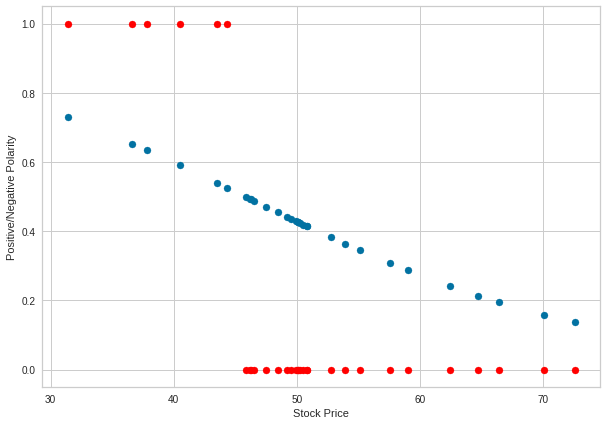

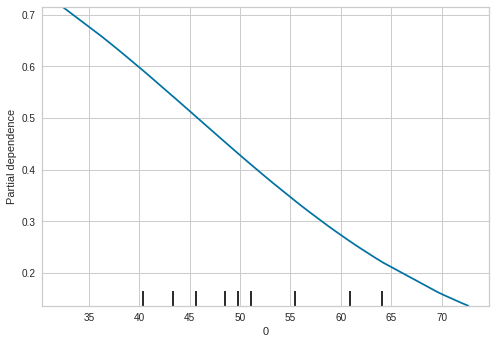

              precision    recall  f1-score   support

           0       0.52      0.72      0.60        18
           1       0.17      0.08      0.11        13

    accuracy                           0.45        31
   macro avg       0.34      0.40      0.35        31
weighted avg       0.37      0.45      0.40        31


Confusion Matrix
[[13  5]
 [12  1]]


In [ ]:

from sklearn.metrics import classification_report
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.special import expit


last =(np.array(merge2["Close"]).reshape(-1,1)) #closing price of stock

label = np.array(merge2["Label"]).reshape(-1,1) #value between 0,1
label = label.astype('int')

X_train,X_test,y_train,y_test=train_test_split(last.astype("float"),label,test_size=0.30,random_state=10)

logReg = LogisticRegression().fit(X_train, y_train)
log_pred = (logReg.predict(X_test))
log_prob = logReg.predict_proba(X_test)

plt.figure(figsize = (10,7))
plt.scatter(X_test,log_pred, color ="red")
plt.scatter(X_test,log_prob[:,1])
plt.xlabel("Stock Price")
plt.ylabel("Positive/Negative Polarity")

plot_partial_dependence(logReg,X_train,features = ["0"])
plt.show()

print(classification_report(y_test,log_pred))

print()
print("Confusion Matrix")
print(confusion_matrix(y_test,log_pred))


R^2: 0.7006847609682731


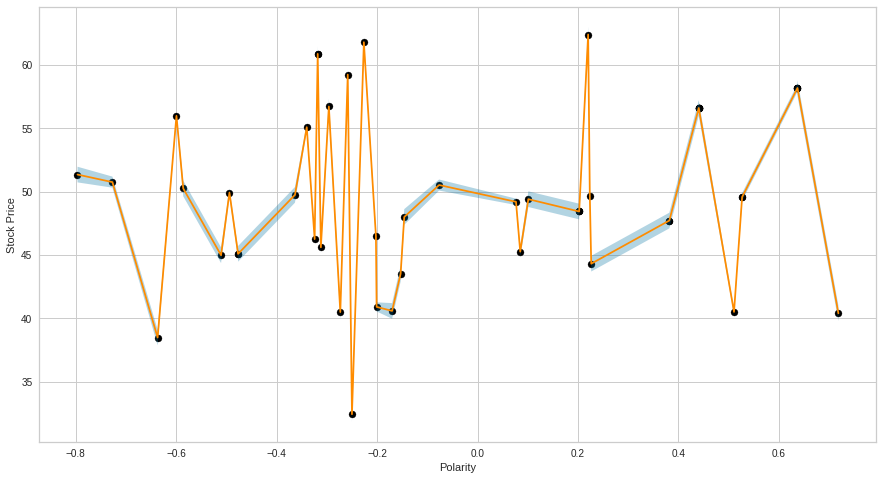

In [ ]:
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C,ExpSineSquared, Matern, RationalQuadratic

pol_score = np.array(merge2["Aggr. Title Polarity"]).reshape(-1,1) #polarity
last_c = np.array(merge2['Close']).reshape(-1,1) #closing price

X_train,X_test,y_train,y_test=train_test_split(pol_score,np.ravel(last_c),test_size=0.5,random_state=0)

kernel = 1.0 * Matern(length_scale=1, nu=2.5)
model = gp.GaussianProcessRegressor(kernel=kernel,optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer=0, alpha=.1, normalize_y=True)

model.fit(X_train, y_train)
y_pred,std= model.predict(X_train, return_std=True)


x,y = zip(*sorted(zip(X_train,y_pred),key=lambda x: x[0])) #I used this function to sort the values, in order to plot the line. 
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
plt.scatter(X_train,y_pred, color = "black")
plt.xlabel("Polarity")
plt.ylabel("Stock Price")
plt.plot(x,y, color = "darkorange")

plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * std, #1.96 from 95% CL on t-table
         (y + 1.9600 * std)[::-1]]),
         alpha=.3, fc='b')
plt.draw()
 
print("R^2:",model.score(X_train,y_train))




0.008484070423779855

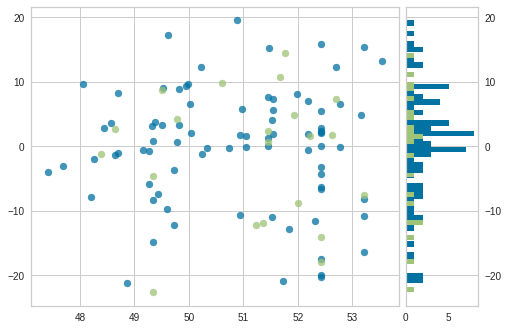

In [ ]:
#Just for my own knowledge. Not part of the project Residual plot. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
X_train,X_test,y_train,y_test=train_test_split(p_score,np.ravel(last_c),test_size=0.2,random_state=0)
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train.astype("float"), y_train.astype("float"))  
visualizer.score(X_test.astype("float"), y_test.astype("float"))  
#train = Blue
#test = green 
